In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input


# Gasoline RBOB

## 7:3

In [2]:
# Đọc dữ liệu
df = pd.read_csv('../dataset/Gasoline RBOB.csv')

In [3]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-27,2.6847,2.6878,2.6976,2.6877,0.15K,-0.59%
1,2024-03-26,2.7006,2.7489,2.7500,2.6980,0.39K,-1.74%
2,2024-03-25,2.7484,2.7370,2.7603,2.7310,0.62K,1.11%
3,2024-03-24,2.7181,2.7115,2.7193,2.7115,NaN,-0.79%
4,2024-03-22,2.7398,2.7090,2.7456,2.7090,0.61K,0.47%
...,...,...,...,...,...,...,...
1618,2019-01-06,1.3690,1.3595,1.3695,1.3570,NaN,-5.68%
1619,2019-01-04,1.4515,1.3364,1.3981,1.3293,66.36K,0.96%
1620,2019-01-03,1.4377,1.3160,1.3676,1.3016,57.75K,1.60%
1621,2019-01-02,1.4150,1.3136,1.3790,1.2685,87.52K,7.81%


In [5]:

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Đảo ngược dữ liệu để dự đoán giá trị trong tương lai
df = df.iloc[::-1].reset_index(drop=True)

In [6]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-01-02,1.4150,1.3136,1.3790,1.2685,87520.0,7.81
1,2019-01-03,1.4377,1.3160,1.3676,1.3016,57750.0,1.60
2,2019-01-04,1.4515,1.3364,1.3981,1.3293,66360.0,0.96
3,2019-01-07,1.4505,1.3560,1.3945,1.3389,79090.0,5.95
4,2019-01-08,1.4740,1.3466,1.3722,1.3385,74920.0,1.62
...,...,...,...,...,...,...,...
1325,2024-03-21,2.7271,2.7370,2.7376,2.7119,150.0,-0.22
1326,2024-03-22,2.7398,2.7090,2.7456,2.7090,610.0,0.47
1327,2024-03-25,2.7484,2.7370,2.7603,2.7310,620.0,1.11
1328,2024-03-26,2.7006,2.7489,2.7500,2.6980,390.0,-1.74


In [7]:
price = df['Price'].values
price = price.reshape(-1, 1)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [9]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [10]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
# Xây dựng mô hình RNN
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
# 11. Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2226
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0095
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0045
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.7851e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.7205e-04
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8812e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4987e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6635e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.3515e-04
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4038e-04
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7799e-04
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.2132e-04
Epoch 15/100
15/15 ━━━

In [13]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [14]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.0780947994437012
MAPE trên tập test là: 2.488981980296855 %
MAE trên tập test là: 0.06178111673219217


In [15]:
last_30_days = price_scaled[-look_back:]
next_30_days = []

for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat[0, 0])
    last_30_days = np.append(last_30_days, y_hat)[-look_back:]

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [16]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1330,2.656635
1331,2.643054
1332,2.624176
1333,2.601841
1334,2.593184
1335,2.580987
1336,2.568699
1337,2.559423
1338,2.551734
1339,2.539345


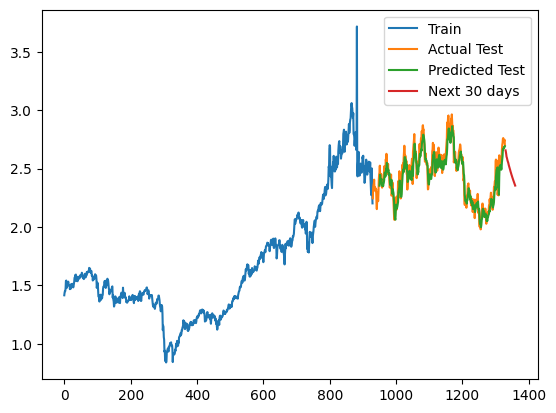

In [17]:
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.savefig('RNN_Gasoline_Oil_73.png') 
plt.show()


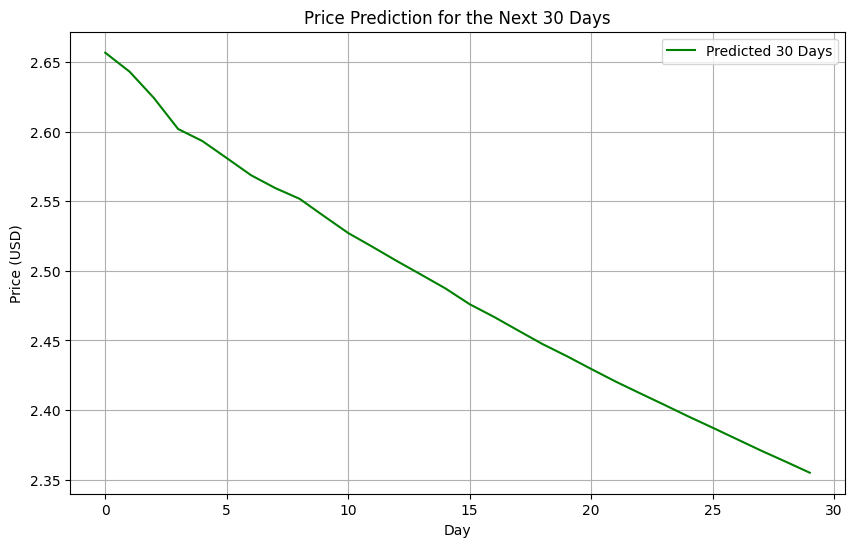

In [18]:
plt.figure(figsize=(10, 6))
predict_30_days_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(predict_30_days_index, next_30_days, label='Predicted 30 Days', color='green')
plt.title('Price Prediction for the Next 30 Days')
plt.xlabel('Day')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 8:2

In [19]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [20]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [21]:
# Xây dựng mô hình RNN
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3301
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0317
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2978e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7289e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.2022e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.8466e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3701e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.6649e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.4178e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4247e-04
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.3234e-04
Epoch 15/100
17/17 ━━━━

In [23]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [24]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.07262975596767414
MAPE trên tập test là: 2.2170076708821287 %
MAE trên tập test là: 0.05398095741271973


In [25]:
last_30_days = price_scaled[-look_back:]
next_30_days = []

for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat[0, 0])
    last_30_days = np.append(last_30_days, y_hat)[-look_back:]

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [26]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1330,2.701415
1331,2.712196
1332,2.716261
1333,2.720362
1334,2.730463
1335,2.736343
1336,2.742289
1337,2.746133
1338,2.751686
1339,2.751070


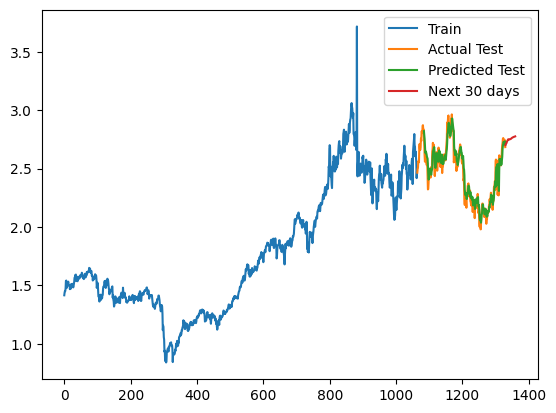

In [27]:
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.savefig('RNN_Gasoline_Oil_82.png') 
plt.show()


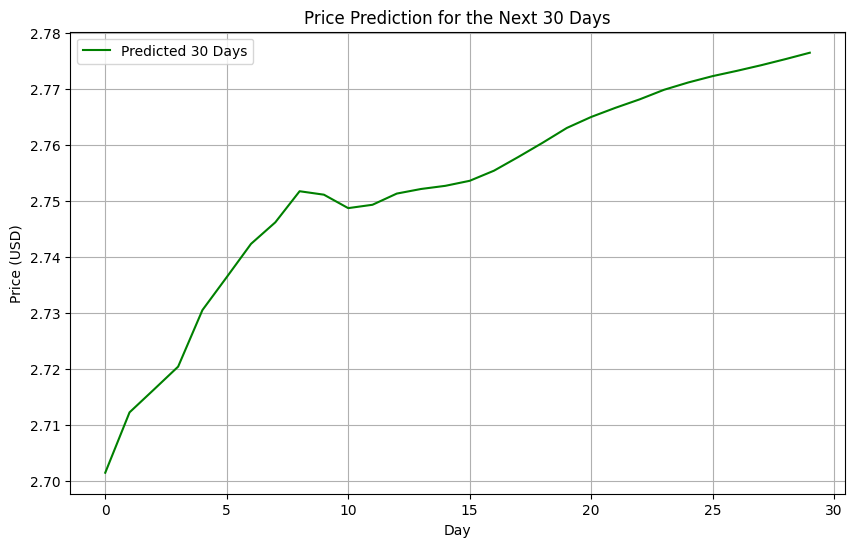

In [28]:
plt.figure(figsize=(10, 6))
predict_30_days_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(predict_30_days_index, next_30_days, label='Predicted 30 Days', color='green')
plt.title('Price Prediction for the Next 30 Days')
plt.xlabel('Day')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### 9:1

In [29]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [30]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [31]:
# Xây dựng mô hình RNN
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [32]:
# 11. Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.9013
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0215
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0052
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.6776e-04
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.7055e-04
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0010
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.9756e-04
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.0585e-04
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0

In [33]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


In [34]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.07184713657694047
MAPE trên tập test là: 2.3214476712619216 %
MAE trên tập test là: 0.05274116573164947


In [35]:
last_30_days = price_scaled[-look_back:]
next_30_days = []

for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat[0, 0])
    last_30_days = np.append(last_30_days, y_hat)[-look_back:]

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [36]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1330,2.708678
1331,2.716155
1332,2.714638
1333,2.714259
1334,2.714554
1335,2.716674
1336,2.713232
1337,2.709006
1338,2.711126
1339,2.710058


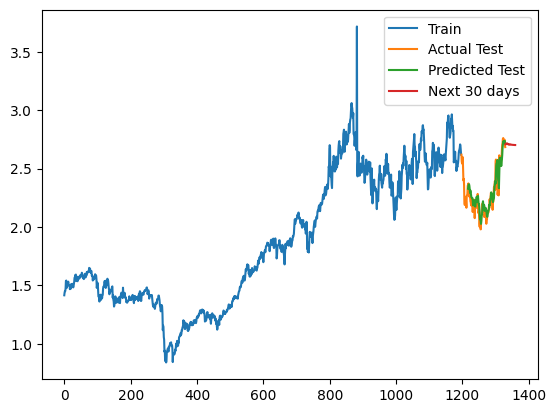

In [37]:
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.savefig('RNN_Gasoline_Oil_91.png') 
plt.show()

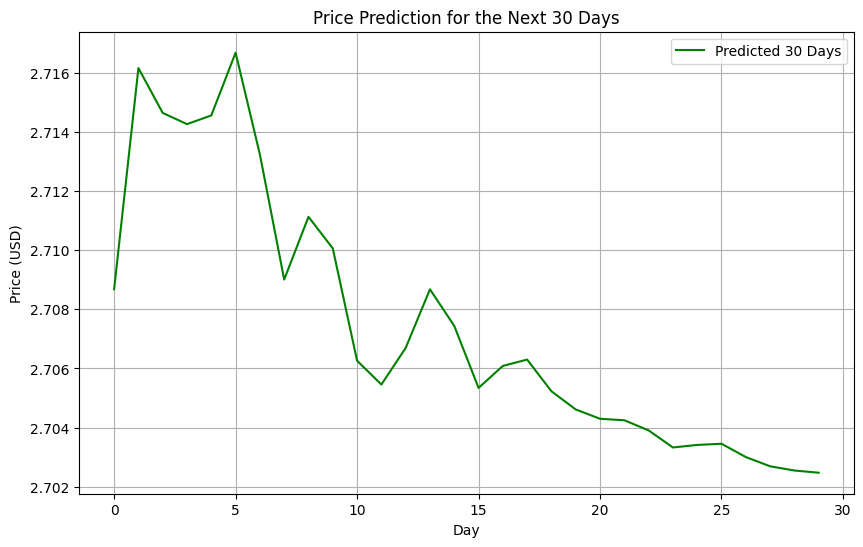

In [38]:
plt.figure(figsize=(10, 6))
predict_30_days_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(predict_30_days_index, next_30_days, label='Predicted 30 Days', color='green')
plt.title('Price Prediction for the Next 30 Days')
plt.xlabel('Day')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()